📊 CREATING MODEL EVALUATION VISUALIZATIONS
🚀 Starting visualization pipeline...

🔧 LOADING MODEL AND GENERATING PREDICTIONS
----------------------------------------
✅ Model loaded successfully
✅ Predictions generated for 15,000 samples
✅ Overall R² Score: 0.7810
✅ Overall MAE: $19,895

📈 CREATING PERFORMANCE VISUALIZATIONS
----------------------------------------


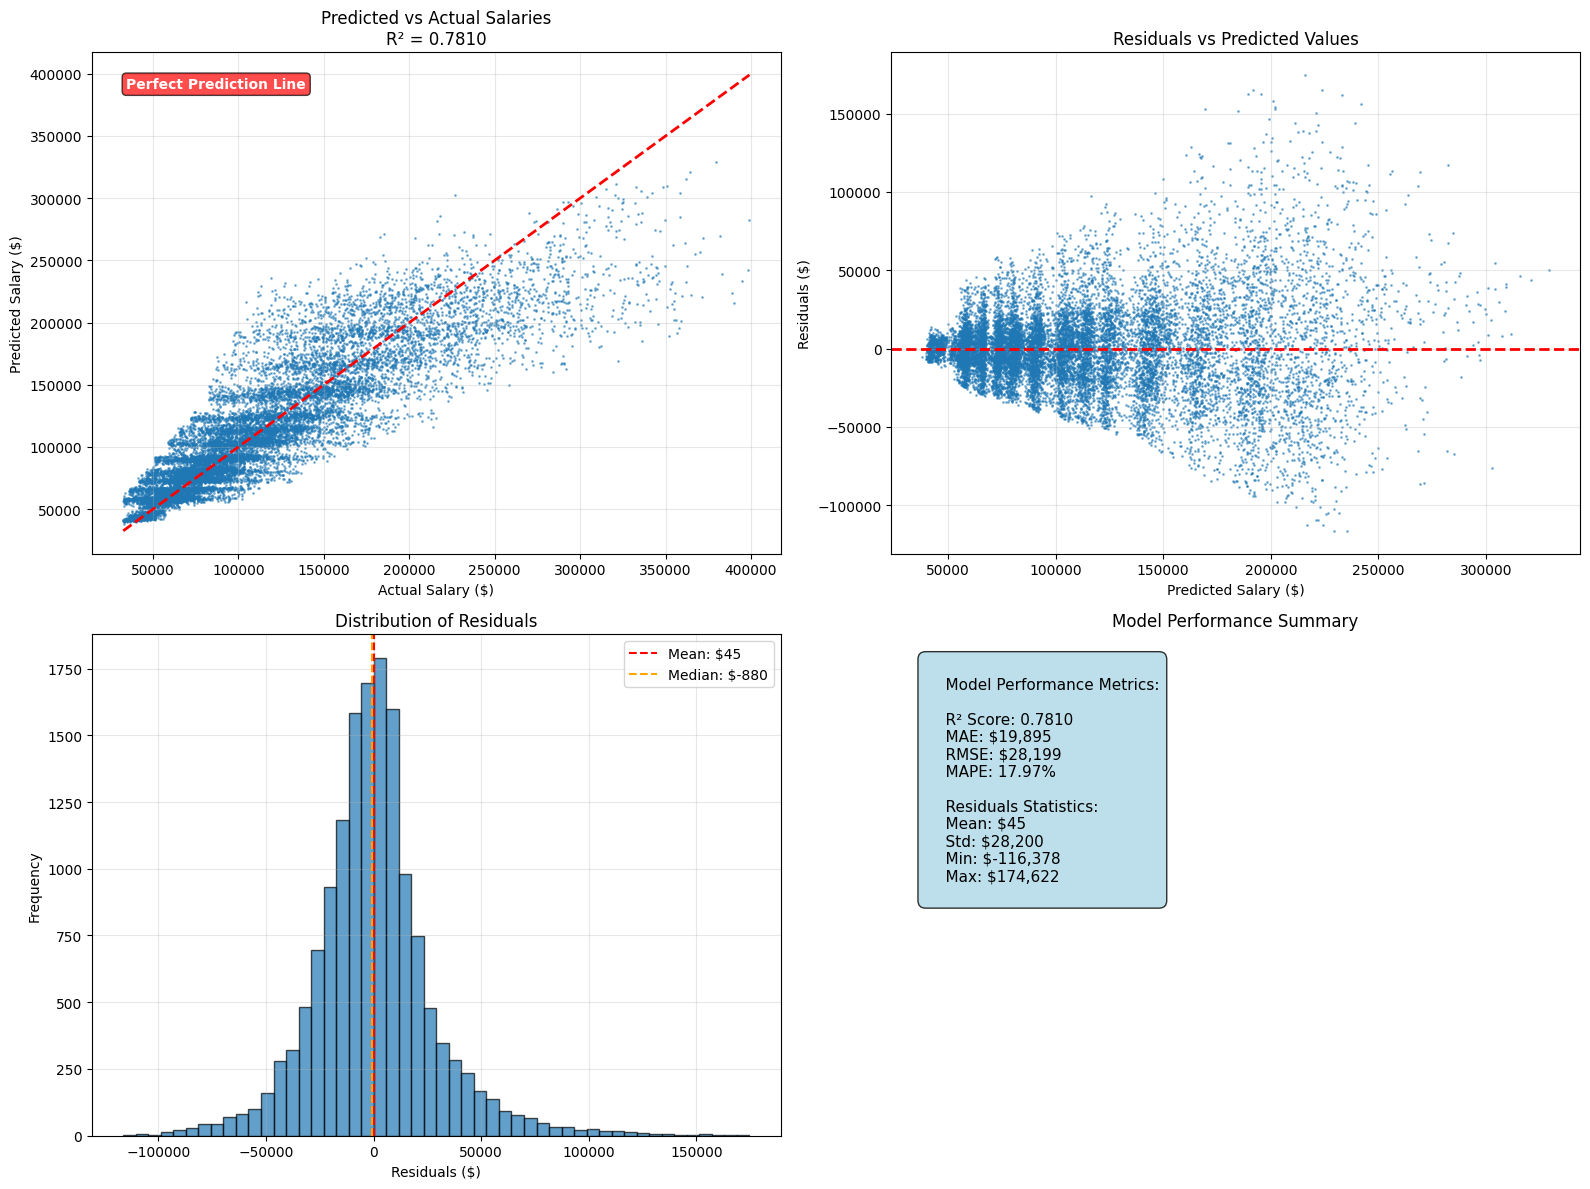

✅ Core performance plots saved as 'model_performance_analysis.png'

🔍 CREATING FEATURE IMPORTANCE VISUALIZATION
----------------------------------------


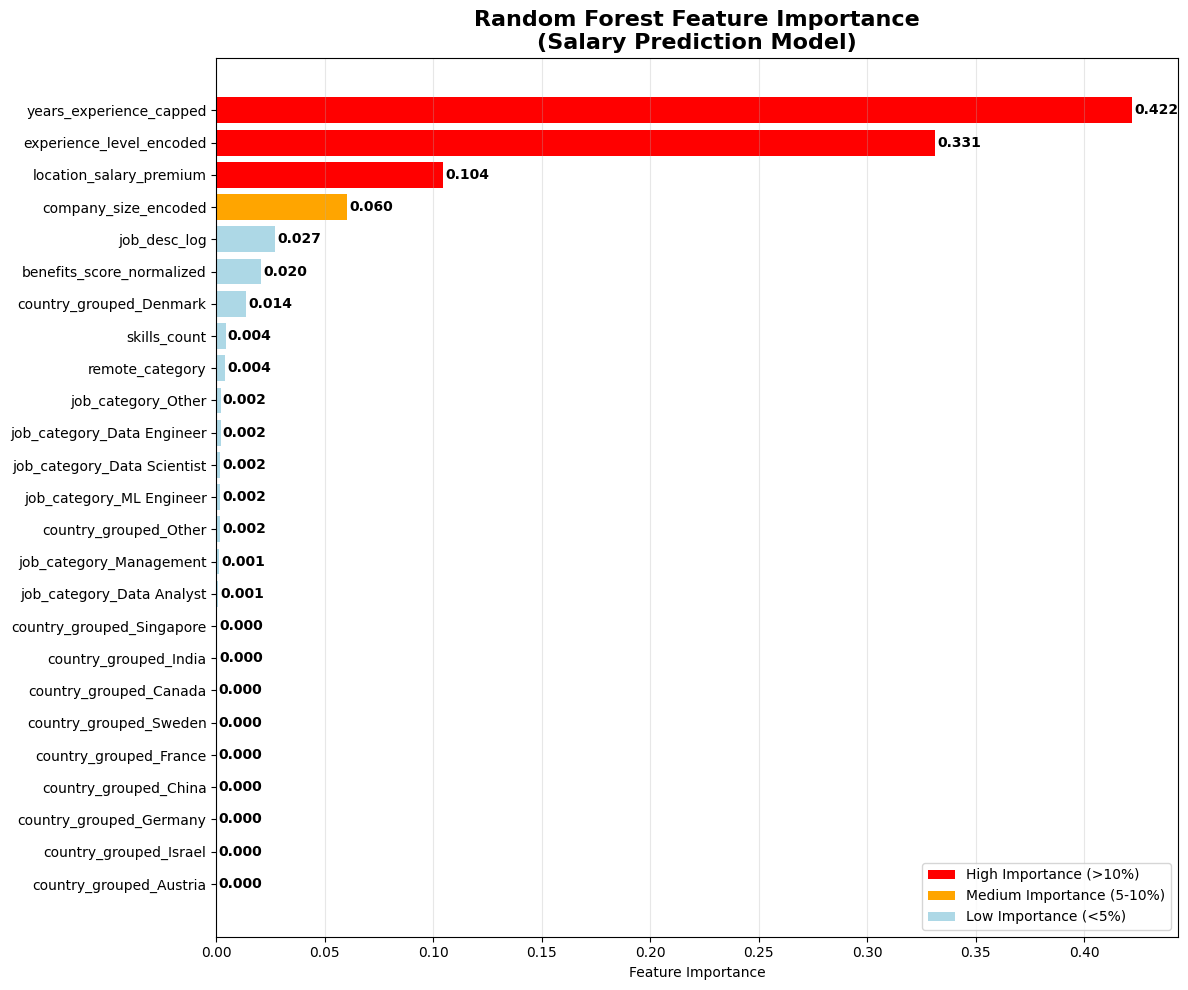

🏆 TOP 10 MOST IMPORTANT FEATURES:
   job_category_Other            : 0.0020
   remote_category               : 0.0039
   skills_count                  : 0.0042
   country_grouped_Denmark       : 0.0136
   benefits_score_normalized     : 0.0205
   job_desc_log                  : 0.0273
   company_size_encoded          : 0.0601
   location_salary_premium       : 0.1043
   experience_level_encoded      : 0.3312
   years_experience_capped       : 0.4220
✅ Feature importance plot saved as 'feature_importance_analysis.png'

🎯 CREATING ERROR ANALYSIS BY SEGMENTS
----------------------------------------


C:\Users\lcchr\AppData\Local\Temp\ipykernel_37620\1532926038.py:229: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_salary = analysis_df.groupby('salary_quartile')['abs_residuals'].agg(['mean', 'median', 'count'])


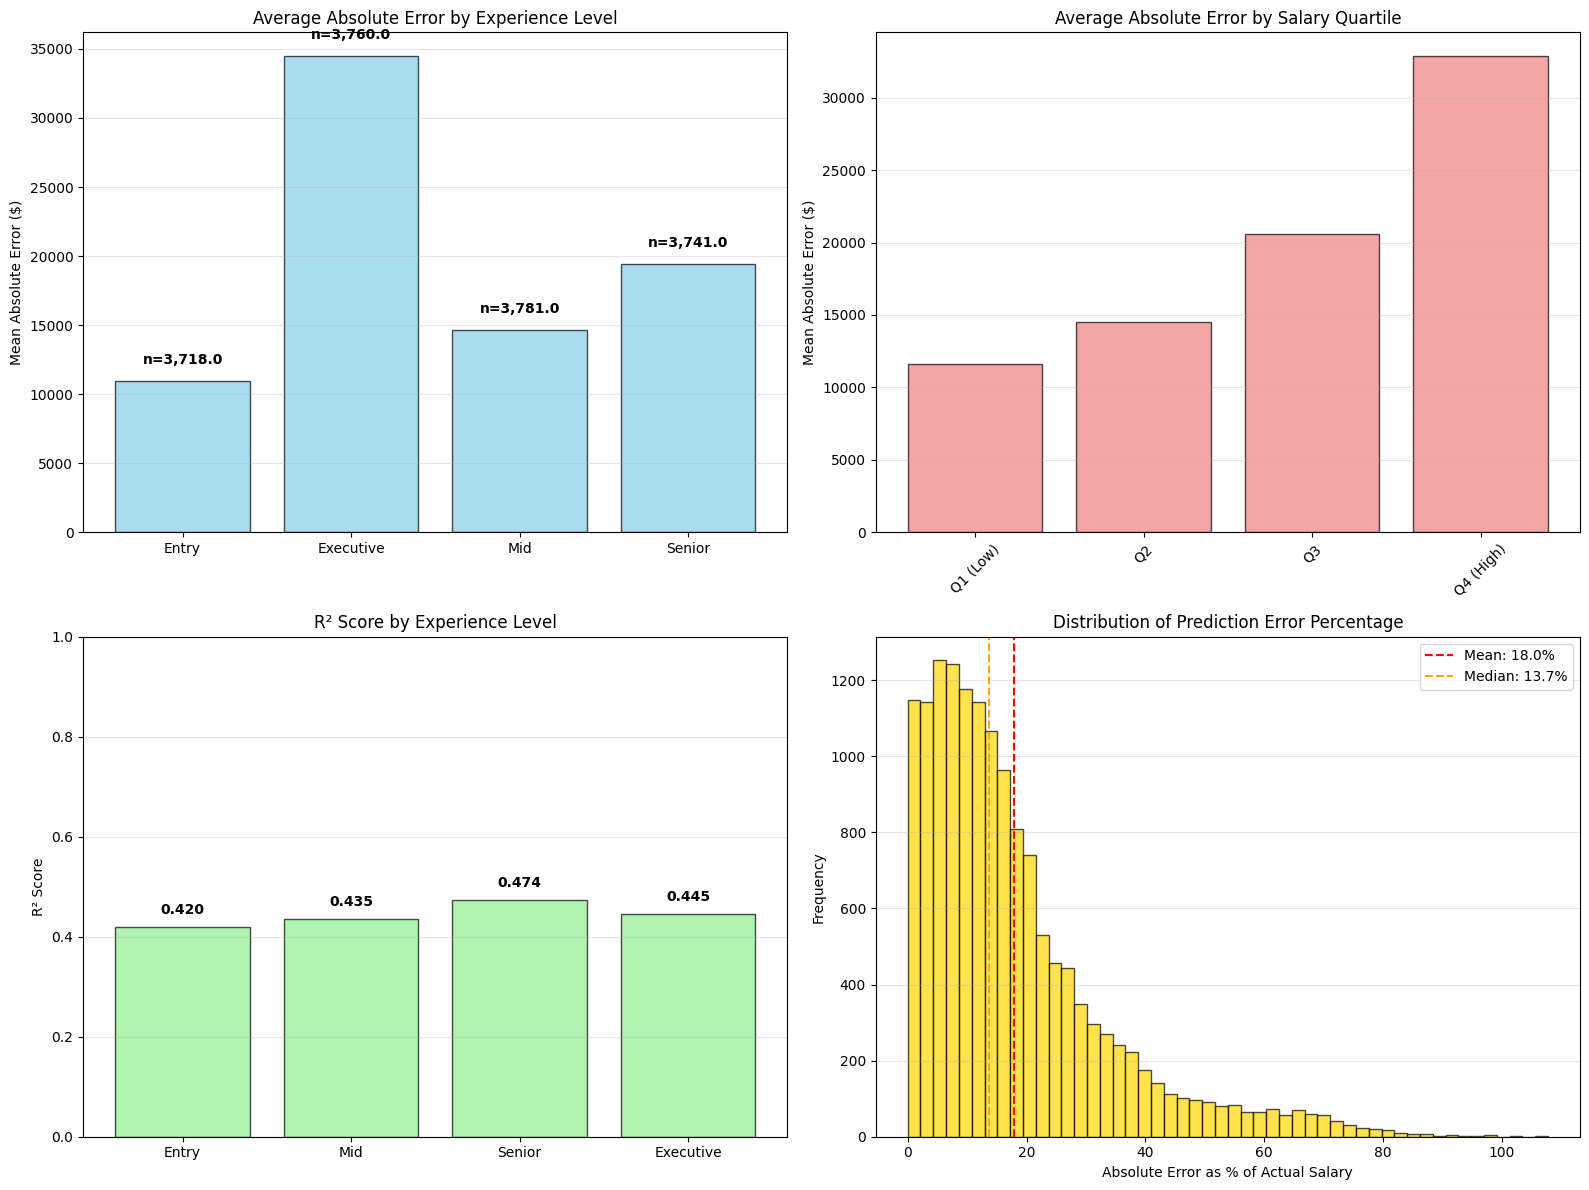

📊 ERROR ANALYSIS SUMMARY:
   Overall MAPE: 17.97%
   Median Error %: 13.68%
   % Predictions within 20%: 68.0%
   % Predictions within 30%: 83.0%
✅ Error analysis plots saved as 'error_analysis_by_segments.png'

🎨 CREATING INTERACTIVE DASHBOARD PREVIEW
----------------------------------------


✅ Interactive dashboard saved as 'interactive_model_dashboard.html'

🎉 VISUALIZATION PIPELINE COMPLETE!
📊 Files created:
   ✅ model_performance_analysis.png
   ✅ feature_importance_analysis.png
   ✅ error_analysis_by_segments.png
   ✅ interactive_model_dashboard.html

🎯 Ready for dashboard integration and capstone documentation!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
from sklearn.metrics import r2_score, mean_absolute_error

print("CREATING MODEL EVALUATION VISUALIZATIONS")
print("=" * 60)

# ============================================================================
# LOAD MODEL AND MAKE PREDICTIONS FOR VISUALIZATION
# ============================================================================

def load_model_and_predict():
    """Load saved model and create predictions for visualization"""
    
    print("LOADING MODEL AND GENERATING PREDICTIONS")
    print("-" * 40)
    
    # Load the saved model
    model = joblib.load('best_salary_prediction_model.pkl')
    
    # Load the test data
    X = pd.read_csv('X_features_for_modeling.csv')
    y = pd.read_csv('y_target_for_modeling.csv')['salary_usd']
    
    # Make predictions on full dataset for comprehensive analysis
    y_pred = model.predict(X)
    
    # Calculate residuals
    residuals = y - y_pred
    
    print(f"Model loaded successfully")
    print(f"Predictions generated for {len(y):,} samples")
    print(f"Overall R² Score: {r2_score(y, y_pred):.4f}")
    print(f"Overall MAE: ${mean_absolute_error(y, y_pred):,.0f}")
    
    return model, X, y, y_pred, residuals

# ============================================================================
# CREATE CORE PERFORMANCE VISUALIZATIONS
# ============================================================================

def create_performance_plots(y_true, y_pred, residuals):
    """Create core model performance visualizations"""
    
    print("CREATING PERFORMANCE VISUALIZATIONS")
    print("-" * 40)
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Predicted vs Actual Scatter Plot
    axes[0,0].scatter(y_true, y_pred, alpha=0.5, s=1)
    axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Salary ($)')
    axes[0,0].set_ylabel('Predicted Salary ($)')
    axes[0,0].set_title(f'Predicted vs Actual Salaries\nR² = {r2_score(y_true, y_pred):.4f}')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add perfect prediction line
    axes[0,0].text(0.05, 0.95, 'Perfect Prediction Line', transform=axes[0,0].transAxes, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                   verticalalignment='top', color='white', fontweight='bold')
    
    # 2. Residuals vs Predicted
    axes[0,1].scatter(y_pred, residuals, alpha=0.5, s=1)
    axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0,1].set_xlabel('Predicted Salary ($)')
    axes[0,1].set_ylabel('Residuals ($)')
    axes[0,1].set_title('Residuals vs Predicted Values')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Residuals Distribution
    axes[1,0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(residuals.mean(), color='red', linestyle='--', 
                      label=f'Mean: ${residuals.mean():,.0f}')
    axes[1,0].axvline(residuals.median(), color='orange', linestyle='--', 
                      label=f'Median: ${residuals.median():,.0f}')
    axes[1,0].set_xlabel('Residuals ($)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Residuals')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Error Metrics Summary
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    metrics_text = f"""
    Model Performance Metrics:
    
    R² Score: {r2:.4f}
    MAE: ${mae:,.0f}
    RMSE: ${rmse:,.0f}
    MAPE: {mape:.2f}%
    
    Residuals Statistics:
    Mean: ${residuals.mean():,.0f}
    Std: ${residuals.std():,.0f}
    Min: ${residuals.min():,.0f}
    Max: ${residuals.max():,.0f}
    """
    
    axes[1,1].text(0.05, 0.95, metrics_text, transform=axes[1,1].transAxes,
                   verticalalignment='top', fontsize=11, 
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    axes[1,1].set_title('Model Performance Summary')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Core performance plots saved as 'model_performance_analysis.png'")

# ============================================================================
# FEATURE IMPORTANCE VISUALIZATION
# ============================================================================

def create_feature_importance_plot(model, feature_names):
    """Create feature importance visualization"""
    
    print("CREATING FEATURE IMPORTANCE VISUALIZATION")
    print("-" * 40)
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    # Create horizontal bar plot
    plt.figure(figsize=(12, 10))
    
    # Color code by importance level
    colors = ['red' if imp > 0.1 else 'orange' if imp > 0.05 else 'lightblue' 
              for imp in importance_df['importance']]
    
    bars = plt.barh(range(len(importance_df)), importance_df['importance'], color=colors)
    
    # Customize the plot
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance\n(Salary Prediction Model)', fontsize=16, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, imp) in enumerate(zip(bars, importance_df['importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{imp:.3f}', ha='left', va='center', fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='High Importance (>10%)'),
        Patch(facecolor='orange', label='Medium Importance (5-10%)'),
        Patch(facecolor='lightblue', label='Low Importance (<5%)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top features
    print("TOP 10 MOST IMPORTANT FEATURES:")
    top_features = importance_df.tail(10)
    for _, row in top_features.iterrows():
        print(f"   {row['feature']:<30}: {row['importance']:.4f}")
    
    print("Feature importance plot saved as 'feature_importance_analysis.png'")
    
    return importance_df

# ============================================================================
# ERROR ANALYSIS BY SEGMENTS
# ============================================================================

def create_error_analysis(X, y_true, y_pred, residuals):
    """Analyze model errors by different segments"""
    
    print("CREATING ERROR ANALYSIS BY SEGMENTS")
    print("-" * 40)
    
    # Create analysis dataframe
    analysis_df = pd.DataFrame({
        'actual_salary': y_true,
        'predicted_salary': y_pred,
        'residuals': residuals,
        'abs_residuals': np.abs(residuals),
        'experience_level': X['experience_level_encoded'],
        'company_size': X['company_size_encoded'],
        'remote_category': X['remote_category']
    })
    
    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Error by Experience Level
    exp_levels = {1: 'Entry', 2: 'Mid', 3: 'Senior', 4: 'Executive'}
    analysis_df['exp_level_name'] = analysis_df['experience_level'].map(exp_levels)
    
    error_by_exp = analysis_df.groupby('exp_level_name')['abs_residuals'].agg(['mean', 'median', 'count'])
    
    axes[0,0].bar(error_by_exp.index, error_by_exp['mean'], alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Average Absolute Error by Experience Level')
    axes[0,0].set_ylabel('Mean Absolute Error ($)')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, (idx, row) in enumerate(error_by_exp.iterrows()):
        axes[0,0].text(i, row['mean'] + 1000, f'n={row["count"]:,}', 
                       ha='center', va='bottom', fontweight='bold')
    
    # 2. Error by Salary Range
    analysis_df['salary_quartile'] = pd.qcut(analysis_df['actual_salary'], 4, 
                                           labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
    
    error_by_salary = analysis_df.groupby('salary_quartile')['abs_residuals'].agg(['mean', 'median', 'count'])
    
    axes[0,1].bar(range(len(error_by_salary)), error_by_salary['mean'], 
                  alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_title('Average Absolute Error by Salary Quartile')
    axes[0,1].set_ylabel('Mean Absolute Error ($)')
    axes[0,1].set_xticks(range(len(error_by_salary)))
    axes[0,1].set_xticklabels(error_by_salary.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. R² by Experience Level
    r2_by_exp = {}
    for level in exp_levels.values():
        mask = analysis_df['exp_level_name'] == level
        if mask.sum() > 0:
            r2_by_exp[level] = r2_score(analysis_df[mask]['actual_salary'], 
                                      analysis_df[mask]['predicted_salary'])
    
    axes[1,0].bar(r2_by_exp.keys(), r2_by_exp.values(), alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_title('R² Score by Experience Level')
    axes[1,0].set_ylabel('R² Score')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Add R² value labels
    for i, (level, r2_val) in enumerate(r2_by_exp.items()):
        axes[1,0].text(i, r2_val + 0.02, f'{r2_val:.3f}', 
                       ha='center', va='bottom', fontweight='bold')
    
    # 4. Prediction Accuracy Distribution
    analysis_df['error_percentage'] = (analysis_df['abs_residuals'] / analysis_df['actual_salary']) * 100
    
    axes[1,1].hist(analysis_df['error_percentage'], bins=50, alpha=0.7, color='gold', edgecolor='black')
    axes[1,1].axvline(analysis_df['error_percentage'].mean(), color='red', linestyle='--',
                      label=f'Mean: {analysis_df["error_percentage"].mean():.1f}%')
    axes[1,1].axvline(analysis_df['error_percentage'].median(), color='orange', linestyle='--',
                      label=f'Median: {analysis_df["error_percentage"].median():.1f}%')
    axes[1,1].set_title('Distribution of Prediction Error Percentage')
    axes[1,1].set_xlabel('Absolute Error as % of Actual Salary')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()
    axes[1,1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('error_analysis_by_segments.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("ERROR ANALYSIS SUMMARY:")
    print(f"   Overall MAPE: {analysis_df['error_percentage'].mean():.2f}%")
    print(f"   Median Error %: {analysis_df['error_percentage'].median():.2f}%")
    print(f"   % Predictions within 20%: {(analysis_df['error_percentage'] <= 20).mean()*100:.1f}%")
    print(f"   % Predictions within 30%: {(analysis_df['error_percentage'] <= 30).mean()*100:.1f}%")
    
    print("Error analysis plots saved as 'error_analysis_by_segments.png'")
    
    return analysis_df

# ============================================================================
# CREATE INTERACTIVE DASHBOARD PREVIEW
# ============================================================================

def create_interactive_dashboard_preview(y_true, y_pred, feature_importance_df):
    """Create interactive visualizations for dashboard integration"""
    
    print("CREATING INTERACTIVE DASHBOARD PREVIEW")
    print("-" * 40)
    
    # Create subplot with multiple interactive charts
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Predicted vs Actual Salaries', 'Top 10 Feature Importance',
                       'Prediction Accuracy Distribution', 'Model Performance Metrics'),
        specs=[[{"type": "scatter"}, {"type": "bar"}],
               [{"type": "histogram"}, {"type": "indicator"}]]
    )
    
    # 1. Interactive Predicted vs Actual scatter
    fig.add_trace(
        go.Scatter(
            x=y_true,
            y=y_pred,
            mode='markers',
            marker=dict(size=4, opacity=0.6, color='blue'),
            name='Predictions',
            hovertemplate='Actual: $%{x:,.0f}<br>Predicted: $%{y:,.0f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add perfect prediction line
    fig.add_trace(
        go.Scatter(
            x=[y_true.min(), y_true.max()],
            y=[y_true.min(), y_true.max()],
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            name='Perfect Prediction',
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 2. Top 10 Feature Importance
    top_10_features = feature_importance_df.tail(10)
    
    fig.add_trace(
        go.Bar(
            x=top_10_features['importance'],
            y=top_10_features['feature'],
            orientation='h',
            marker_color='lightblue',
            name='Feature Importance'
        ),
        row=1, col=2
    )
    
    # 3. Error distribution
    residuals = y_true - y_pred
    error_pct = (np.abs(residuals) / y_true) * 100
    
    fig.add_trace(
        go.Histogram(
            x=error_pct,
            nbinsx=30,
            marker_color='gold',
            name='Error Distribution',
            hovertemplate='Error Range: %{x:.1f}%<br>Count: %{y}<extra></extra>'
        ),
        row=2, col=1
    )
    
    # 4. Key Performance Indicators
    r2_score_val = r2_score(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    
    fig.add_trace(
        go.Indicator(
            mode="gauge+number+delta",
            value=r2_score_val,
            domain={'x': [0, 1], 'y': [0, 1]},
            title={'text': "Model R² Score"},
            gauge={
                'axis': {'range': [None, 1]},
                'bar': {'color': "darkblue"},
                'steps': [
                    {'range': [0, 0.5], 'color': "lightgray"},
                    {'range': [0.5, 0.7], 'color': "yellow"},
                    {'range': [0.7, 1], 'color': "green"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 0.8
                }
            }
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text="AI Salary Prediction Model - Performance Dashboard",
        showlegend=False
    )
    
    # Save and show
    fig.write_html("interactive_model_dashboard.html")
    fig.show()
    
    print("Interactive dashboard saved as 'interactive_model_dashboard.html'")

# ============================================================================
# EXECUTE COMPLETE VISUALIZATION PIPELINE
# ============================================================================

print("Starting visualization pipeline...")

# Load model and generate predictions
model, X, y_true, y_pred, residuals = load_model_and_predict()

# Create core performance visualizations
create_performance_plots(y_true, y_pred, residuals)

# Create feature importance plot
feature_importance_df = create_feature_importance_plot(model, X.columns)

# Create error analysis by segments
analysis_df = create_error_analysis(X, y_true, y_pred, residuals)

# Create interactive dashboard preview
create_interactive_dashboard_preview(y_true, y_pred, feature_importance_df)

print(f"Pipeline complete!")